In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch


## Dataset generation

In [2]:
df = pd.read_parquet("../RAGtruth/data.parquet")
df = df[df["task_type"] == "QA"]

df["labels"] = df["labels"].apply(lambda x: False if len(x) == 0 else x)
df["labels"] = df["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)

# Filter rows where labels are not False
positive_labels = df[df["labels"] != False]
llama = df[df["model"].str.contains("llama")]

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks_l = split_dataframe(positive_labels, chunk_size=100)
chunks = split_dataframe(df, chunk_size=100)

# Classifier based on LLM-as-a-judge model

In [123]:
# Read all parquet files for answer_relevancy

unbalanced = [3, 4, 6, 7, 16]
balanced = [4, 5, 9]

paths = [f"../llama3-70b-8192/AR_{i}*.parquet" for i in unbalanced] + [
    f"../llama3-70b-8192/l_AR_{i}*.parquet" for i in balanced
]

answer_relevancies = []

for path in paths:
    answer_relevancy_files = glob.glob(path)
    answer_relevancy = pd.concat(
        [pd.read_parquet(f) for f in answer_relevancy_files], axis=1, ignore_index=True
    )
    answer_relevancy = answer_relevancy.mean(axis=1)
    answer_relevancies.append(answer_relevancy)
answer_relevancy = pd.concat(answer_relevancies, ignore_index=True)



paths = [f"../llama3-70b-8192/faithful_{i}*.parquet" for i in unbalanced] + [
    f"../llama3-70b-8192/l_faithful_{i}*.parquet" for i in balanced
]

faithfulnesses = []
for path in paths:
    faithfulness_files = glob.glob(path)
    faithfulness = pd.concat(
        [pd.read_parquet(f) for f in faithfulness_files], axis=1, ignore_index=True
    )
    faithfulness = faithfulness.mean(axis=1)
    faithfulnesses.append(faithfulness)

faithfulness = pd.concat(faithfulnesses, ignore_index=True)

temperature = pd.concat(
    [pd.DataFrame(chunks[i]["temperature"]) for i in unbalanced]
    + [pd.DataFrame(chunks_l[i]["temperature"]) for i in balanced],
    ignore_index=True,
)

In [5]:
files = glob.glob("backup/data_1*.parquet")

df = pd.concat([pd.read_parquet(f) for f in files]).groupby(level=0).mean()
df = pd.concat([pd.read_parquet("backup/data_3_1.parquet"), df])
df.drop(columns=["temperature"], inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=["label"])
y = df["label"]
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)
# restrictive_index = y.isin(
#     [
#         0, 1, 2
#     ]
# )
# y = y[restrictive_index]
# X = X[restrictive_index]
y = (y > 0).astype(int)

In [6]:
# X = pd.concat([temperature, answer_relevancy, faithfulness], axis=1)
# y = pd.concat(
#     [chunks[i]["labels"] for i in unbalanced]
#     + [chunks_l[i]["labels"] for i in balanced],
#     ignore_index=True,
# )
# label_mapping = {label: idx for idx, label in enumerate(y.unique())}
# y = y.map(label_mapping)

# restrictive_index = y.isin(
#     [
#         label_mapping[False],
#         label_mapping["Evident Baseless Info"],
#         label_mapping["Evident Conflict"],
#     ]
# )
# y = y[restrictive_index]
# X = X[restrictive_index]
# y = (y > 0).astype(int)

In [7]:
X_I, X_eval, y_I, y_eval = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_calibr, y_train, y_calibr = train_test_split(X_I, y_I, test_size=0.2, random_state=40)

In [8]:
class BasicMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, output_size),
        )

    def forward(self, x):
        return self.ffnn(x)

In [9]:
model = BasicMLP(X_train.shape[1], len(y.value_counts().index))
optimizer = optim.Adam(
    model.parameters(),
)
loss_fn = nn.CrossEntropyLoss()

In [10]:
x_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

EPOCH 1:
2.210853934288025
EPOCH 6:
2.2565045952796936
EPOCH 11:
2.117994487285614
EPOCH 16:
2.0408167839050293
EPOCH 21:
2.1061859130859375
EPOCH 26:
2.0221109986305237
EPOCH 31:
2.0294336676597595
EPOCH 36:
2.035559356212616
EPOCH 41:
2.0294466614723206
EPOCH 46:
1.9815481305122375
EPOCH 51:
2.1076773405075073
EPOCH 56:
1.966216802597046
EPOCH 61:
1.9951230883598328
EPOCH 66:
2.02164888381958
EPOCH 71:
1.9709582328796387
EPOCH 76:
2.024225115776062
EPOCH 81:
2.014155924320221
EPOCH 86:
1.9798539876937866
EPOCH 91:
1.9648517370224
EPOCH 96:
1.9274412989616394
EPOCH 101:
1.9970316886901855
EPOCH 106:
1.888490378856659
EPOCH 111:
1.9017136693000793
EPOCH 116:
1.856062889099121
EPOCH 121:
1.9592499136924744
EPOCH 126:
1.9087474942207336
EPOCH 131:
1.875105857849121
EPOCH 136:
1.912028968334198
EPOCH 141:
1.819079577922821
EPOCH 146:
1.8212329149246216
EPOCH 151:
1.8110384345054626
EPOCH 156:
1.7862354516983032
EPOCH 161:
1.8362753987312317
EPOCH 166:
1.7635398507118225
EPOCH 171:
1.72940

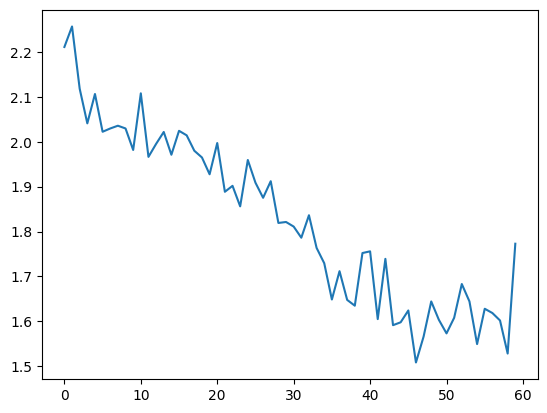

In [11]:
EPOCHS = 300

losses = []
for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        losses.append(running_loss)
        print(running_loss)

plt.plot(losses)

In [16]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

log = LogisticRegression(penalty='l2')
knn = KNeighborsClassifier(n_neighbors=4)
lgbm = LGBMClassifier()

lgbm.fit(X_train, y_train)
knn.fit(X_train.values, y_train)

[LightGBM] [Info] Number of positive: 120, number of negative: 164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 284, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422535 -> initscore=-0.312375
[LightGBM] [Info] Start training from score -0.312375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

KNeighborsClassifier(n_neighbors=4)

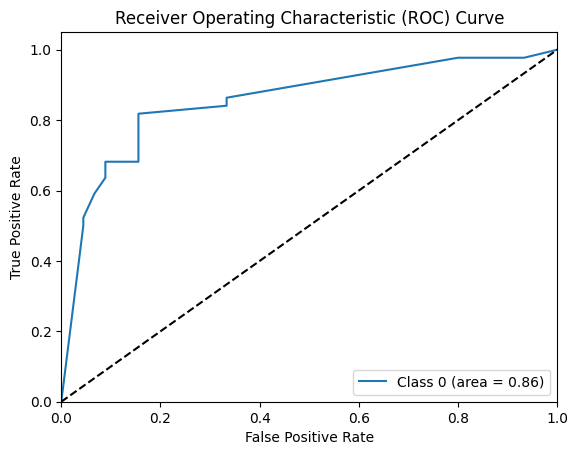

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(y_eval, lgbm.predict(X_eval))
# Print classification report
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_eval))

for i in range(n_classes - 1):
    fpr[i], tpr[i], _ = roc_curve(y_eval == i, lgbm.predict_proba(X_eval)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes - 1):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

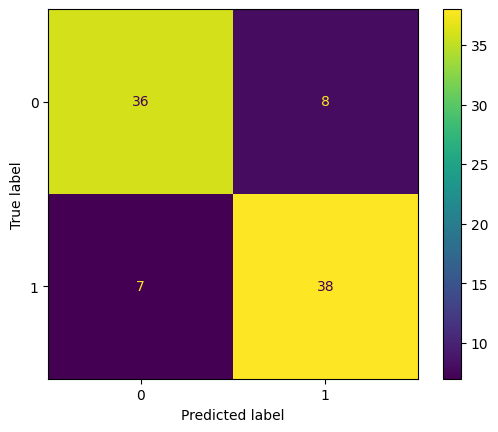

In [18]:
ConfusionMatrixDisplay(cm).plot()

In [77]:
X_tensor_calibr = torch.tensor(X_calibr.to_numpy(), dtype=torch.float32)
y_tensor_calibr = torch.tensor(y_calibr.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_calibr, y_tensor_calibr)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [78]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

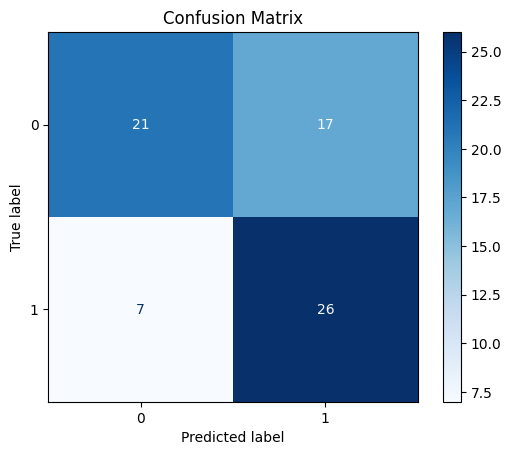

Pearson correlation coefficient: 0.32258336235314483
0.6619718309859155
              precision    recall  f1-score   support

           0       0.75      0.55      0.64        38
           1       0.60      0.79      0.68        33

    accuracy                           0.66        71
   macro avg       0.68      0.67      0.66        71
weighted avg       0.68      0.66      0.66        71

Pearson correlation coefficient for lgbm: 0.32258336235314483
Kendall's tau correlation: 0.2869239291548366
Kendall's tau correlation for lgbm: 0.2869239291548366


In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

true_labels = []
predicted_labels = []
probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
probs = np.array(probs)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(true_labels, probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(true_labels, predicted_labels))
# print(accuracy_score(true_labels, lgbm.predict(X_eval)))
print(classification_report(true_labels, predicted_labels))

# pearson_corr, _ = pearsonr(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Pearson correlation coefficient for lgbm: {pearson_corr}")
# Compute Kendall's tau correlation
kendall_tau, _ = kendalltau(true_labels, probs[:, 1])
print(f"Kendall's tau correlation: {kendall_tau}")

# kendall_tau, _ = kendalltau(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Kendall's tau correlation for lgbm: {kendall_tau}")

fpr = dict()
# tpr = dict()
# roc_auc = dict()
# n_classes = len(np.unique(y_eval))

# for i in range(n_classes - 1):
#     fpr[i], tpr[i], _ = roc_curve(y_eval == i, probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curve
# plt.figure()
# for i in range(n_classes - 1):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.savefig("roc_curve.png")
# plt.show()

In [93]:
s = 1 - probs[np.arange(len(true_labels)), true_labels]
s = np.sort(s)
q = np.quantile(s, 0.5)
q

0.4032555818557739

In [94]:
X_tensor_eval = torch.tensor(X_eval.to_numpy(), dtype=torch.float32)
y_tensor_eval = torch.tensor(y_eval.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_eval, y_tensor_eval)
true_test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

tensor([[0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.4089, 0.5864],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.4537, 0.5606],
        [0.7308, 0.3595],
        [0.7455, 0.3497],
        [0.6266, 0.4367],
        [0.5091, 0.5172],
        [0.4365, 0.5706],
        [0.3906, 0.5967],
        [0.3906, 0.5967],
        [0.4280, 0.5757],
        [0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.7308, 0.3595],
        [0.4089, 0.5864],
        [0.4280, 0.5757],
        [0.5281, 0.5065],
        [0.4089, 0.5864],
        [0.4790, 0.5457],
        [0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.3906, 0.5967],
        [0.7308, 0.3595],
        [0.7308, 0.3595],
        [0.7308, 0.3595],
        [0.3906, 0.5967],
        [0.7504, 0.3475],
        [0.7308, 0.3595],
        [0.7

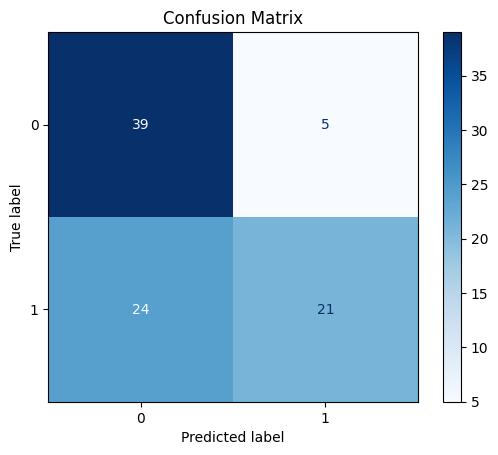

Pearson correlation coefficient: 0.6185150437740263
0.6741573033707865
              precision    recall  f1-score   support

           0       0.62      0.89      0.73        44
           1       0.81      0.47      0.59        45

    accuracy                           0.67        89
   macro avg       0.71      0.68      0.66        89
weighted avg       0.71      0.67      0.66        89



In [95]:
eval_true_labels = []
eval_predicted_labels = []
eval_probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in true_test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        print(probabilities)
        # Compute argmax for class prediction
        predictions = probabilities[:, 1] >= 1 - q
        print(predictions)
        
        # Store true and predicted labels
        eval_true_labels.extend(labels.cpu().numpy())
        eval_predicted_labels.extend(predictions.cpu().numpy())
        eval_probs.extend(probabilities.cpu().numpy())

eval_true_labels = np.array(eval_true_labels)
eval_predicted_labels = np.array(eval_predicted_labels)
eval_probs = np.array(eval_probs)

cm = confusion_matrix(eval_true_labels, eval_predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(eval_true_labels, eval_probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(eval_true_labels, eval_predicted_labels))
# print(accuracy_score(true_labels, lgbm.predict(X_eval)))
print(classification_report(eval_true_labels, eval_predicted_labels))



## True test set

In [22]:
test_n = 8
faithfulness_files = glob.glob(f"../llama3-70b-8192/faithful_{test_n}*")
ar_files = glob.glob(f"../llama3-70b-8192/AR_{test_n}*")


faithfulness = pd.concat(
    [pd.read_parquet(f) for f in faithfulness_files], axis=1, ignore_index=True
)
faithfulness = faithfulness.mean(axis=1)
ar = pd.concat(
    [pd.read_parquet(f) for f in ar_files], axis=1, ignore_index=True
)
ar = ar.mean(axis=1)

temperature =  pd.DataFrame(chunks[test_n]["temperature"])

X_test = pd.concat([temperature, ar, faithfulness], axis=1)
y_test = pd.concat(
    [
        chunks[test_n]["labels"],
    ],
    ignore_index=True,
)

y_test = y_test.map(label_mapping)

y_test = (y_test > 0).astype(int)

NameError: name 'chunks' is not defined

In [139]:
x_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)
dataset = TensorDataset(x_tensor_test, y_tensor_test)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

Pearson correlation coefficient: 0.24051746628468976
Kendall's tau correlation: 0.1786448538301852


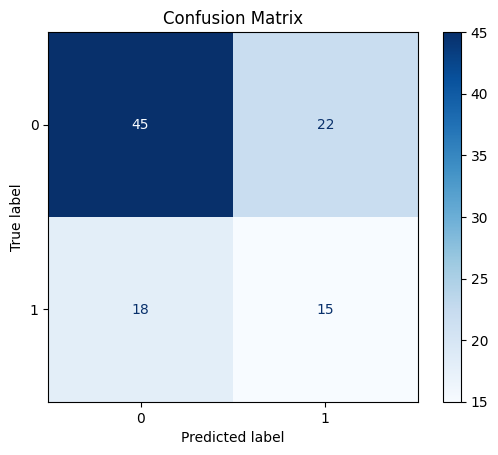

In [140]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []
probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = torch.sigmoid(outputs)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
probs = np.array(probs)


pearson_corr, _ = pearsonr(true_labels, probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

kendall_tau, _ = kendalltau(true_labels, probs[:, 1])
print(f"Kendall's tau correlation: {kendall_tau}")
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

## Robustness study

In [141]:
test_bench = pd.read_parquet("../llama3-70b-8192/faithful_4.parquet")
test_1 = pd.read_parquet("../llama3-70b-8192/faithful_4_1.parquet")
test_2 = pd.read_parquet("../llama3-70b-8192/faithful_4_2.parquet")
test_3 = pd.read_parquet("../llama3-70b-8192/faithful_4_3.parquet")

idx = test_bench.sort_values(by="faithfulness").index
test_bench = test_bench.loc[idx]
test_1 = test_1.loc[idx]
test_2 = test_2.loc[idx]
test_3 = test_3.loc[idx]
test_bench["faithfulness1"] = test_1["faithfulness"]
test_bench["faithfulness2"] = test_2["faithfulness"]
test_bench["faithfulness3"] = test_3["faithfulness"]
rho1 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness1"])
rho2 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness2"])
rho3 = np.corrcoef(test_bench["faithfulness"], test_bench["faithfulness3"])
rho4 = np.corrcoef(test_bench["faithfulness2"], test_bench["faithfulness3"])
rho5 = np.corrcoef(test_bench["faithfulness1"], test_bench["faithfulness2"])
rho6 = np.corrcoef(test_bench["faithfulness1"], test_bench["faithfulness3"])
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness1"] / 2,
    marker="x",
    label=f"data 1->2 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness2"] / 2,
    marker="x",
    label=f"data 1->3 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness"] / 2,
    test_bench["faithfulness3"] / 2,
    marker="x",
    label=f"data 1->4 corr={rho3[0, 1]:2f}",
)
plt.scatter(
    test_bench["faithfulness2"] / 2,
    test_bench["faithfulness3"] / 2,
    marker="x",
    label=f"data 3->4 corr={rho4[0, 1]:2f}",
)
print([rho1[0, 1], rho2[0, 1], rho3[0, 1], rho4[0, 1], rho5[0, 1], rho6[0, 1]])
plt.legend()
plt.plot([0, 1], [0, 1], "k--", label="$y=x$")

plt.title("llama3-70b-8192")
plt.xlabel("faithfulness on left side")
plt.ylabel("faithfulness on ride side")

FileNotFoundError: [Errno 2] No such file or directory: '../llama3-70b-8192/faithful_4.parquet'

[0.6241648133640948, 0.5983287618020778, 0.5992270596844883, 0.570183939402625, 0.6432532271743, 0.47536152306578816]


Text(0, 0.5, 'AR on $k$th gen')

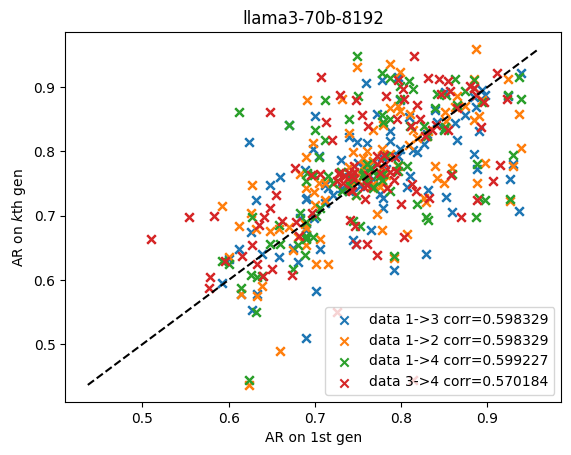

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

test_bench = pd.read_parquet("./llama3-70b-8192/AR_4.parquet")
test_1 = pd.read_parquet("./llama3-70b-8192/AR_4_1.parquet")
test_2 = pd.read_parquet("./llama3-70b-8192/AR_4_2.parquet")
test_3 = pd.read_parquet("./llama3-70b-8192/AR_4_3.parquet")

idx = test_bench.sort_values(by="AR").index
test_bench = test_bench.loc[idx]
test_1 = test_1.loc[idx]
test_2 = test_2.loc[idx]
test_3 = test_3.loc[idx]
test_bench["AR1"] = test_1["AR"]
test_bench["AR2"] = test_2["AR"]
test_bench["AR3"] = test_3["AR"]

rho1 = np.corrcoef(test_bench["AR"], test_bench["AR1"])
rho2 = np.corrcoef(test_bench["AR"], test_bench["AR2"])
rho3 = np.corrcoef(test_bench["AR"], test_bench["AR3"])
rho4 = np.corrcoef(test_bench["AR2"], test_bench["AR3"])
rho5 = np.corrcoef(test_bench["AR1"], test_bench["AR3"])
rho6 = np.corrcoef(test_bench["AR1"], test_bench["AR2"])
plt.scatter(
    test_bench["AR"],
    test_bench["AR2"],
    marker="x",
    label=f"data 1->3 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR"],
    test_bench["AR1"],
    marker="x",
    label=f"data 1->2 corr={rho2[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR"],
    test_bench["AR3"],
    marker="x",
    label=f"data 1->4 corr={rho3[0, 1]:2f}",
)
plt.scatter(
    test_bench["AR2"],
    test_bench["AR3"],
    marker="x",
    label=f"data 3->4 corr={rho4[0, 1]:2f}",
)
print([rho1[0, 1], rho2[0, 1], rho3[0, 1], rho4[0, 1], rho5[0, 1], rho6[0, 1]])

plt.legend()
plt.plot(
    [test_bench.min().min(), test_bench.max().max()],
    [test_bench.min().min(), test_bench.max().max()],
    "k--",
    label="$y=x$",
)

plt.title("llama3-70b-8192")
plt.xlabel("AR on 1st gen")
plt.ylabel("AR on $k$th gen")